# Постановка Дифференциальной Задачи

$$
- \nabla ^ 2 u = f, u|_{\partial \Omega} = \alpha, \alpha = \text{const}, \Omega = [0, 1] ^2
$$

Для существования и единственности решения достаточно непрерывности функций $f$ и $\alpha$. Поскольку $\alpha = \text{const}$, в нашем случае достаточно непрерывности $f(x, y)$.

## Собственные функции

Известно, что для оператора Лапласа с граничным условием Дирихле вида $u|_{\partial \Omega} = 0$ на квадрате $\Omega = [0, 1] ^2$ собственными функциями являются $\sin(n \pi x) \sin(m \pi y), n, m \in \mathbb{N}_0$ с собственными значениями $(n \pi)^2 + (m \pi)^2$

# Построение Дискретной Задачи

Требуется построить разностную схему со вторым порядком аппроксимации.

Построим сетку $\{x_i = a + ih, i = 0 ... n\} \times \{y_j = c + jk, i = 0 ... m\}$. Тут n, m являются числом частей, на которые разбиваются стороны прямоугольной области, $(a, c)$ являются координатами "нижнего левого" угла. Если координаты "правого верхнего" $(b, d)$, то $h = \frac{b - a}{n}$, а $k = \frac{d - c}{m}$. В нашем случае $a = c = 0$, $b = d = 1$.

Внутренними точками области являются $\{x_i = a + ih, i = 1 ... n - 1\} \times \{y_j = c + jk, i = 1 ... m - 1\}$

Напишем код, делающий это и что-нибудь нарисуем:

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from ggplot import *

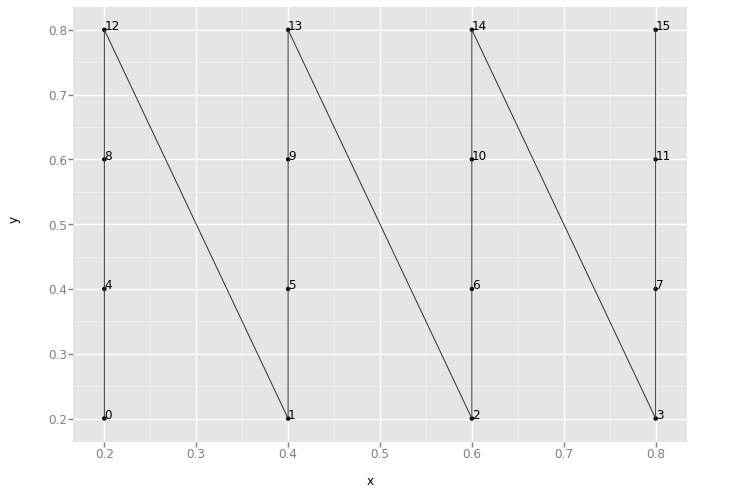

<ggplot: (-9223372036583559108)>

In [2]:
class ij_to_l:
    def __init__(self, x_division, y_division):
        self.x_division = x_division
        self.y_division = y_division
        
    def __call__(self, x_it, y_it):
        if x_it == 0 or x_it == self.x_division or y_it == 0 or y_it == self.y_division:
            raise Exception("Out of bounds")
        return x_it - 1 + (y_it - 1) * (self.x_division - 1)


class l_to_ij:
    def __init__(self, x_division, y_division):
        self.x_division = x_division
        self.y_division = y_division

    def __call__(self, l):
        return (l % (self.x_division), l // (self.x_division))

ijl = ij_to_l(5, 5)
points = pd.DataFrame(columns=["x", "y", "id"])

for x_it in range(1, 5):
    for y_it in range(1, 5):
        l = ijl(x_it, y_it)
        new_row = {"x": x_it / 5, "y": y_it / 5, "id": l}
        points.loc[l] = new_row
points.id = points.id.astype("int")
plot = ggplot(aes(x='x', y='y', label="id"), data=points) + geom_point() + geom_text()
display(plot)

## Доказательство аппроксимации

Докажем, что $\frac{u(x_{i + 1}, y_j) - 2 u(x_{i}, y_j) + u(x_{i - 1}, y_j)}{h ^ 2}$ является разностной аппроксимацией 2-го порядка оператора $\frac{\partial^2 u}{\partial x^2}$. Разлагая в ряд Тейлора:

$$
\frac{u(x_{i + 1}, y_j) - 2 u(x_{i}, y_j) + u(x_{i - 1}, y_j)}{h ^ 2} =
$$
$$
=\frac{u(x_{i}, y_j) + \frac{\partial u}{\partial x} h + \frac{1 \partial^2 u}{2 \partial x^2} h^2 + \frac{1 \partial^3 u}{6 \partial x^3} h^3 - 2 u(x_{i}, y_j) + u(x_{i}, y_j) - \frac{\partial u}{\partial x} h + \frac{1\partial^2 u}{2 \partial x^2} h^2 - \frac{1 \partial^3 u}{6 \partial x^3} h^3 + O(h^4)}{h^2} = 
$$
$$
= \frac{
        \frac{\partial^2 u}{\partial x^2} h^2 + O(h^4)
       }{h^2}
= \frac{\partial^2 u}{\partial x^2} + O(h^2)
$$


Значит, $\frac{u(x_{i + 1}, y_j) - 2 u(x_{i}, y_j) + u(x_{i - 1}, y_j)}{h ^ 2} +
\frac{u(x_{i}, y_{j + 1}) - 2 u(x_{i}, y_j) + u(x_{i}, y_{j - 1})}{k ^ 2}$ аппроксимирует
$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$ с точностью $O(h^2 + k^2)$

## Доказательство сходимости дискретной задачи к дифференциальной

## Собственно, система

Для начала стоит сконструировать матрицу системы, чтобы ее просто посмотреть. Конструировать будем в lil формате, чтобы иметь линейный по числу узлов расход памяти:

(принять решение, будет ли сетка равномерной и, если нет, делить матрицу системы на $h$ и $k$)

In [3]:
from scipy.sparse import lil_matrix

def f(x, y):
    return x + y

def g(x, y):
    return 1


def construct_finite_difference_matrices(x_start=0, x_finish=1, y_start=0, y_finish=1,
                                         x_division=4, y_division=4, f=f, g=g):
    ij_l = ij_to_l(x_division, y_division)
    l_ij = l_to_ij(x_division, y_division)
    x_step = (x_finish - x_start) / x_division
    y_step = (y_finish - y_start) / y_division
    x = np.linspace(x_start, x_finish, num=x_division + 1)
    y = np.linspace(y_start, y_finish, num=y_division + 1)
    inner_points_count = (x_division - 1) * (y_division - 1)
    A = lil_matrix((inner_points_count, inner_points_count))
    b = np.zeros((inner_points_count, 1))
    w = np.zeros((x_division + 1, y_division + 1))
    for x_it in range(1, x_division):
        for y_it in range(1, y_division):
            l = ij_l(x_it, y_it)
            A[l, l] = 4
            b[l] = g(x[x_it], y[y_it])
            left = (x_it - 1, y_it)
            if left[0] == 0:
                b[l] += g(x[left[0]], y[left[1]])
            else:
                A[l, ij_l(*left)] = -1
            right = (x_it + 1, y_it)
            if right[0] == x_division:
                b[l] += g(x[right[0]], y[right[1]])
            else:
                A[l, ij_l(*right)] = -1
            up = (x_it, y_it + 1)
            if up[1] == y_division:
                b[l] += g(x[up[0]], y[up[1]])
            else:
                A[l, ij_l(*up)] = -1
            down = (x_it, y_it - 1)
            if down[1] == 0:
                b[l] += g(x[down[0]], y[down[1]])
            else:
                A[l, ij_l(*down)] = -1
    return A, b

    
A, b = construct_finite_difference_matrices()
A = A.todense()
print(A)

[[ 4. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  4.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  4. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  4.]]


# Методы Решения Дискретной Задачи

## Линейный 2-шаговый Оптимальный Процесс

(Написать полные выкладки)

Нам потребуются точные границы спектра матрицы аппроксимации Лапласиана.

Известно, что для кронекеровской суммы операторов собственные значения будут являться различными попарными суммами значений исходных матриц. Поскольку собственными значениями одномерной дискретизации лапласиана центральной суммой являются $4 \sin ^ 2 (\frac{\pi j}{2 (n + 1)}), j \in {1 ... n}$, то минимумом и максимумом собственных значений аппроксимации двумерного Лапласиана будут $8 \sin ^ 2 (\frac{\pi}{2 (n + 1)})$ и $8 \sin ^ 2 (\frac{\pi n}{2 (n + 1)})$
соответственно. Сравним вычисления по этим формулам с значениями, находимыми библиотечными функциями:

In [4]:
from math import sin, pi

w, v = np.linalg.eig(A)
indmin = np.argmin(w)
indmax = np.argmax(w)
print(w[indmin], w[indmax])
print(8 * (sin(pi * 1 / 8) ** 2), 8 * (sin(pi * 3 / 8) ** 2))

1.17157287525 6.82842712475
1.17157287525381 6.82842712474619


## Метод Переменных Направлений

# Результаты Работы Программы